# LMBTR Descriptor Generation and NN Training

This notebook demonstrates the process of generating Local Many-Body Tensor Representation (LMBTR) descriptors from Gaussian output files, training a neural network on this data, and using the model for predictions.

## Setup
Ensure you have the necessary libraries installed. The `dscribe` library is essential for this workflow.

In [9]:
# !pip install dscribe scikit-learn torch matplotlib pandas tqdm numpy

## 1. Import Libraries

We import the necessary libraries, including our custom utility module `lmbtr_utils`.

In [10]:
import numpy as np
import lmbtr_utils as lu # Import our new utility module

## 2. Generate Descriptor DataFrame from Gaussian Outputs

We read all Gaussian output files from the specified directory, calculate LMBTR descriptors for the `Li` atoms, and combine them with their corresponding isotropic chemical shielding values into a single DataFrame.

In [11]:
df_all = lu.create_descriptor_dataframe(
    gout_folder_path='./dataset',
    central_atoms=['Li'],
    k2_grid_n=20, # Using published data value would be n=200
    k3_grid_n=20
)

print(f"Generated DataFrame with shape: {df_all.shape}")
df_all.head()

Processing Gaussian Output Files:   0%|          | 0/100 [00:00<?, ?it/s]c:\Users\nagoriyuki\miniconda3\envs\organize_upload\Lib\site-packages\dscribe\core\system.py:90: FutureWarning: Please use atoms.calc
  calculator=atoms.get_calculator(),
Processing Gaussian Output Files: 100%|██████████| 100/100 [00:02<00:00, 43.44it/s]

Generated DataFrame with shape: (100, 2)


,X,y
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",92.6243
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",92.8762
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",93.1346
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",92.2859
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",93.0472


## 3. Save and Reload Data

First, we extract the feature (X) and target (y) arrays from the DataFrame and save them to a CSV file. Then, we load the data back from the CSV, simulating a common workflow where data processing and model training are separate steps.

In [12]:
# Save the processed data to a CSV file
_, _ = lu.extract_and_save_csv(df_all, output_path='cut-data.csv', save_to_file=True)

# Load the data back from the CSV file
X, yo = lu.load_features_from_csv('cut-data.csv')

Data saved to cut-data.csv


INFO:root:Loaded data from cut-data.csv
INFO:root:Processed X column, shape: (100, 2000)
INFO:root:Processed y column, shape: (100,)


## 4. Preprocess Data and Train Model

We normalize the target variable `y` and then use the preprocessed data to train our neural network. The trained model state is saved to a file.

In [13]:
# Normalize the target variable `y`
mean_value = np.mean(yo)
std_value = np.std(yo)
y = (yo - mean_value) / std_value
print(f"Normalization - Mean: {mean_value:.4f}, Std: {std_value:.4f}\n")

# Train the model and save its state
model, y_test_norm, y_pred_norm, test_loss = lu.train_evaluate_and_save_model(
    X,
    y,
    model_save_path="lmbtr_model.pth",
    num_epochs=1000, # Reduced for quick demonstration
    save_model=True
)

Normalization - Mean: 92.6444, Std: 0.3491

Epoch 1/1000, Val Loss: 1.5699
Epoch 101/1000, Val Loss: 0.6853
Epoch 201/1000, Val Loss: 0.6876
Epoch 301/1000, Val Loss: 0.6878
Epoch 401/1000, Val Loss: 0.6906
Epoch 501/1000, Val Loss: 0.7027
Epoch 601/1000, Val Loss: 0.6838
Epoch 701/1000, Val Loss: 0.6850
Epoch 801/1000, Val Loss: 0.6825
Epoch 901/1000, Val Loss: 0.6821
Final Test Loss: 0.5934
Saved PyTorch Model State to lmbtr_model.pth


## 5. Evaluate and Visualize Results

Using the test set predictions from the training step, we calculate key regression metrics and generate a parity plot to visualize model performance. The plot is both displayed and saved.

MAE: 0.2251
RMSE: 0.2689
R2 Score: 0.2741
Figure saved to 000pearson.jpg


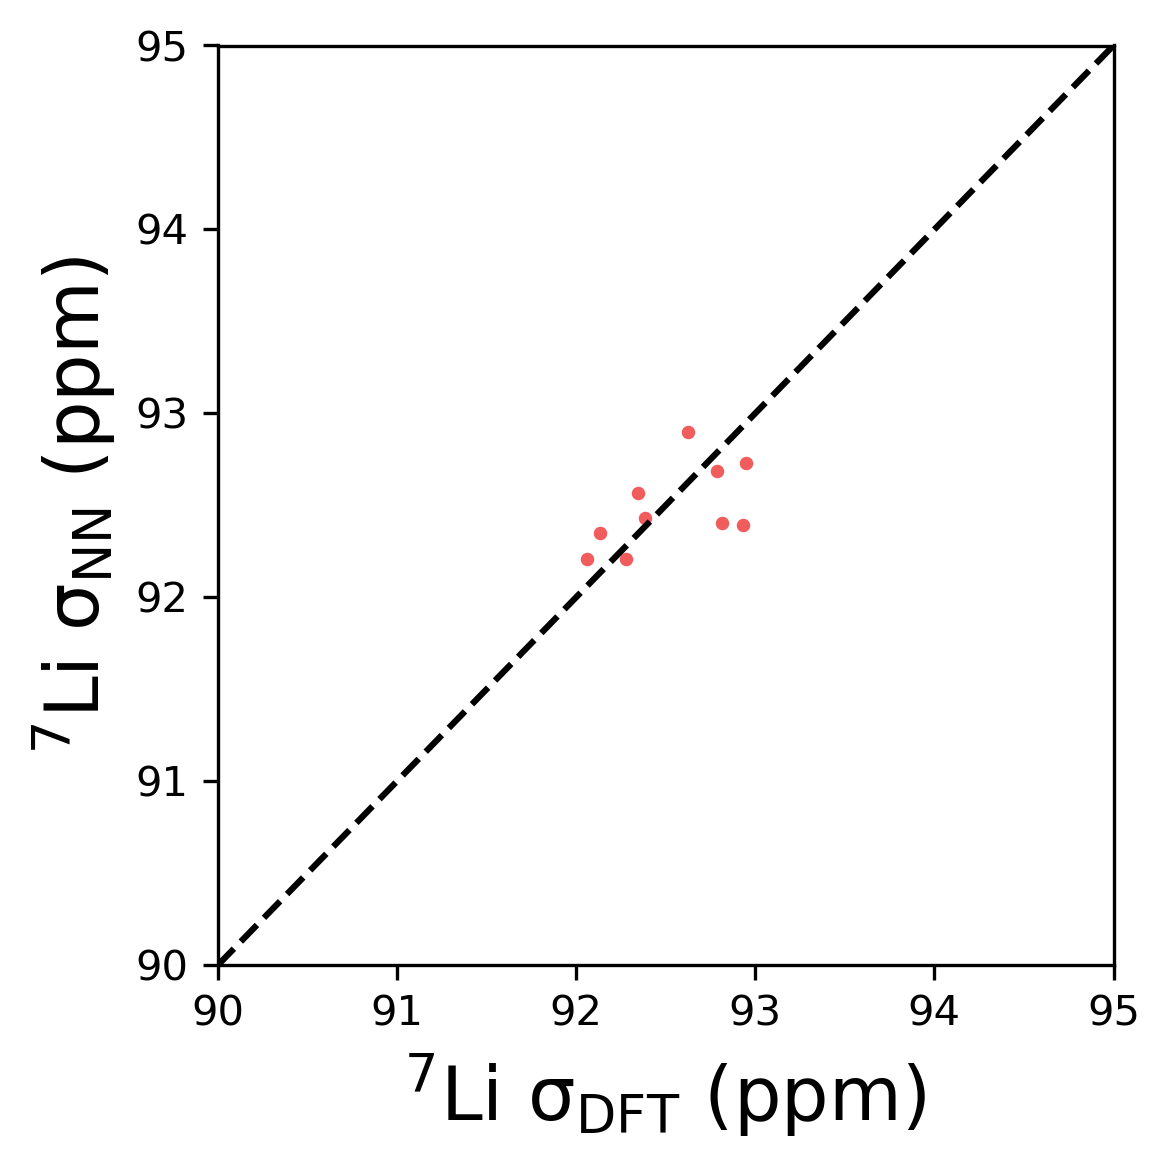

In [14]:
metrics = lu.plot_predictions(
    y_true_normalized=y_test_norm,
    y_pred_normalized=y_pred_norm,
    mean_value=mean_value,
    std_value=std_value,
    figure_save_path="000pearson.jpg",
    enable_plotting=True,
    save_figure=True,
    xlim=(90, 95),
    ylim=(90, 95)
)

## 6. Predict on New Data

Finally, we load the saved model and use it to predict the chemical shielding for a new set of descriptors stored in a `.pkl` file. This demonstrates the model's application in a prediction workflow.

In [15]:
predictions = lu.predict_with_saved_model(
    model_path="lmbtr_model.pth",
    input_dim=X.shape[1],
    pkl_file_path="fsi.pkl",
    mean_value=mean_value,
    std_value=std_value
)

print("Predictions on new data:")
for i, p in enumerate(predictions[:5]): # Print first 5 predictions
    print(f"  Sample {i}: Predicted \u03c3 = {p['de_pred'][0]:.4f} ppm")

Predictions on new data:
  Sample 0: Predicted σ = 92.5886 ppm
  Sample 1: Predicted σ = 92.5749 ppm
  Sample 2: Predicted σ = 92.6853 ppm
  Sample 3: Predicted σ = 92.5132 ppm
  Sample 4: Predicted σ = 92.5721 ppm


c:\Users\nagoriyuki\VSCodeProjects\organize_upload\lmbtr_utils.py:401: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locatio